In [1]:
import os
from datetime import datetime
from keras.models import *
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Activation, Flatten, Dense, UpSampling2D
from keras.models import *
from keras.optimizers import SGD,Adam,Adagrad,Nadam,RMSprop
# from keras.losses import binary_crossentropy
# from keras.metrics import binary_accuracy
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

Using TensorFlow backend.


### Create directories

In [2]:

def create_folder(_fold_path):
    try:
        os.makedirs(_fold_path)
    except OSError:
        print("***folder already exist***")

### define network

In [3]:

def simpleCNN(input_shape=(48, 48, 3), classes=1):
    img_input = Input(shape=input_shape)
    bn_axis = 3

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, decoded)
    return model

### Training model

In [4]:
# train model
def train_model(model, loss, metrics, optimizer, epochs=25):
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    model.summary()
    history = model.fit_generator(
        train_generator,
        # steps_per_epoch=num_train_samples // batch_size,
        
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_generator,
        class_weight='auto',
        steps_per_epoch=50,
        validation_steps=30,
        # validation_steps=num_val_samples // batch_size,
    )
    return model


In [5]:
if __name__ == '__main__':
    # dimensions of our images.
    IM_HEIGHT, IM_WIDTH, IM_CHANNEL = 32, 32, 3
    NB_EPOCHS = 20
    BAT_SIZE = 16
    FC_SIZE = 1024
    # data path
    _data_path = './asset/data/'
    train_data_dir = _data_path+"train/"
    valid_data_dir = _data_path+"valid/"
    test_data_dir = _data_path+"test/"

    train_datagen = ImageDataGenerator(
        # preprocessing_function = crop_img,
        rescale=1. / 255,   # orignal image is 0~255
        #shear_range=0.2,    # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        #zoom_range=0.2,     # Float or [lower, upper]. Range for random zoom. If a float, 
        #featurewise_center=True,    # Boolean. Set input mean to 0 over the dataset, feature-wise.
        #featurewise_std_normalization=True, # Boolean. Divide inputs by std of the dataset, feature-wise.
       # rotation_range=20,  # int. Degree range for random rotations.
        #width_shift_range=0.2,  # float: fraction of total width, if < 1, or pixels if >= 1.
        #height_shift_range=0.2, # float: fraction of total height, if < 1, or pixels if >= 1.
       # horizontal_flip=True,   # Boolean. Randomly flip inputs horizontally.
        #vertical_flip = True,   # Boolean. Randomly flip inputs vertically.
        )

In [6]:
 # augmentation configuration use for validation and testing only rescaling
val_datagen = ImageDataGenerator(
        rescale=1. / 255,   
    )

In [7]:
test_datagen = ImageDataGenerator(
        rescale=1. / 255,   
    )

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(IM_HEIGHT, IM_WIDTH), # resize the images
        batch_size=BAT_SIZE,
        class_mode="input"
    )

Found 244 images belonging to 2 classes.


In [10]:
val_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(IM_HEIGHT, IM_WIDTH),  # resize the images
        batch_size=BAT_SIZE,
        class_mode="input",
        shuffle=False
    )

Found 10 images belonging to 1 classes.


In [11]:
# the samples and classes generated by the generator 
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples
num_classes = train_generator.num_classes


ts = datetime.now().strftime("%Y-%m%d-%H%M")
_log_dir = './logs/log-{ts}/'.format(ts=ts)
    
if not os.path.exists(_log_dir):
    os.makedirs(_log_dir)
tensorboard = TensorBoard(log_dir=_log_dir)

callbacks = []
callbacks.append(tensorboard)

save_dir = './models/save-{ts}/'.format(ts=ts)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
filepath= save_dir+"improve-{epoch:02d}-{val_acc:.2f}.h5"
    
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, mode='max')
callbacks.append(checkpoint)


In [12]:

# To initialize the model
model = simpleCNN(input_shape=(IM_HEIGHT,IM_WIDTH,IM_CHANNEL), classes=num_classes)
# The methods of optimization
opt = Nadam(lr = 0.002)

model = train_model(model, loss='binary_crossentropy', metrics=['accuracy'], optimizer='adadelta', epochs=NB_EPOCHS)

print("\n #################### Save last model ###################### \n")
ts = datetime.now().strftime("%Y-%m%d-%H%M")
model.save(save_dir+'model-{ts}.h5'.format(ts=ts))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          4624      
__________

## Visualize original image and reconstructed image

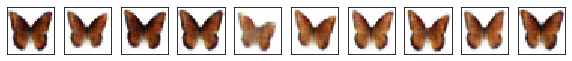

In [15]:
import matplotlib.pyplot as plt
import cv2
import matplotlib
decoded_imgs = model.predict_generator(val_generator,steps=1)
train_data_dir_female=train_data_dir+"female/"
n=10
plt.figure(figsize=(10,4))
for i in range(n):
    # display original
    # ax = plt.subplot(2, n, i+1)
    #plt.imshow(decoded_imgs[i].reshape(32, 32,3))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    # display restruction 
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    matplotlib.image.imsave(train_data_dir_female+str(i)+'.jpg', decoded_imgs[i].reshape(32,32,3))
plt.show()

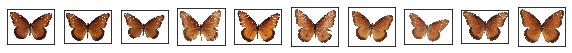

In [16]:
import glob
import matplotlib.pyplot as plt

img_path = glob.glob("./asset/data/test/test_image/*.jpg")
i=0;
plt.figure(figsize=(10,4))

for img in img_path:
    a=plt.imread(img)
    i=i+1;
    ax = plt.subplot(4, 10,i)
    plt.imshow(a)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    
plt.show()

# Exercise  1 Training a model with generated images

In [47]:
# To import the layers

In [48]:
## 2 Read data and Rescale data



# dimensions of our images.

# data path

# imageGenerator
############################
## Insert your code here ###
############################

In [49]:
## back up for read data from folds

# To set up the training and val directory


Found 244 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Found 10 images belonging to 1 classes.


In [50]:
input_shape = (150, 150, 3)

In [ ]:
## (2) build CNN model


In [ ]:
# fit the model

In [ ]:
## (3) Visualization 



In [54]:
## (4) Test
# Evaluate the model on the test data using `evaluate`


1/1 [==============================] - 0s 293ms/step
[[9.97543216e-01]
 [9.99999285e-01]
 [6.80859739e-05]
 [9.97605681e-01]
 [5.52283891e-04]
 [4.86299454e-04]
 [5.46873035e-03]
 [1.04079405e-02]
 [2.62485236e-01]
 [1.84873017e-04]]
